In [1]:
!which python

/mnt/home/moham147/experiments/manifold-learning/.venv/bin/python


# Generate data

check if float32 impacts storage size

does using BILINEAR make it faster

In [19]:
from clock_dataset import draw_clock
    generate_clock_dataset(resolution=1)



Hours: 100%|██████████| 12/12 [00:20<00:00,  1.75s/it]


Saved 720 clock images and features to 'data/clocks.pth'


In [21]:
from PIL import Image
from IPython.display import display
import torch

data = torch.load("data/clocks.pth")


In [24]:
data['images'][0].unsqueeze(0).shape

torch.Size([1, 128, 128])

# Autoencoder

# Regressors

# Datasets

In [1]:
from torch.utils.data import DataLoader
from clock_dataset import ClockDataset
import numpy as np
import matplotlib.pyplot as plt

BATCH_SIZE = 64

# Load supervised dataset
train_dataset = ClockDataset()
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [2]:
# print shape of batches
for batch, labels_2d, labels_1d in train_loader:
    print(f"Batch of images shape: {batch.shape}")
    print(f"Batch of 2D labels shape: {labels_2d.shape}")
    print(f"Batch of 1D labels shape: {labels_1d.shape}")
    break

# print example of data point
idx = np.random.randint(0, len(train_dataset))
batch, labels_2d, labels_1d = train_dataset[idx]

plt.imshow(batch.squeeze(), cmap="gray")


RuntimeError: output with shape [1, 128, 128] doesn't match the broadcast shape [1, 1, 128, 128]

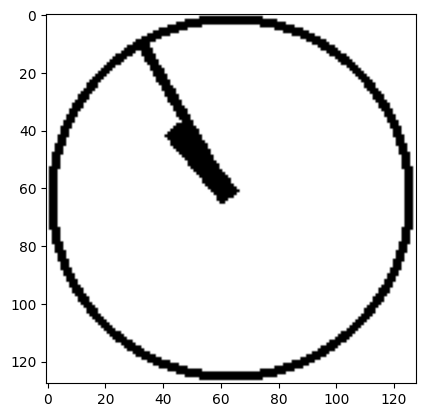

In [3]:
from clock_dataset import ClockGenerator
import matplotlib.pyplot as plt

g = ClockGenerator()

img = g.generate_clock_tensor(4, 20)

plt.imshow(img.squeeze().cpu().numpy(), cmap="gray")

# Train Autoencoder

In [3]:
ae = DeepAutoencoder(n_hidden=2)

# count number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters in autoencoder: {count_parameters(ae)}")

Number of parameters in autoencoder: 70442243


In [ ]:

OUT_DIM = 2
LEARNING_RATE = 0.0002

ae = DeepAutoencoder(n_hidden=OUT_DIM)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(ae.parameters(), lr=LEARNING_RATE)

# Training loop for autoencoder
num_epochs = 3
for epoch in range(num_epochs):
    for batch in unsupervised_loader:
        # Forward pass
        reconstructed, _ = ae(batch) # Get reconstructed image, ignore latent
        loss = criterion(reconstructed, batch)
        print(loss.item())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x32768 and 131072x256)

# Train regressors

In [10]:

LEARNING_RATE = 0.0002

regressor = ClockRegressor(out_dim=2)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(regressor.parameters(), lr=LEARNING_RATE)

# Training loop for regressor
num_epochs = 3
for epoch in range(num_epochs):
    for batch, labels_2d, labels_1d in train_loader:
        # Forward pass
        outputs = regressor(batch)
        loss = criterion(outputs, labels_2d)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    

0.09335006773471832
0.08971729129552841
0.07255273312330246
0.10962341725826263
0.07685185968875885
0.07334550470113754
0.08128383755683899
0.0822688490152359
0.08242283761501312


KeyboardInterrupt: 

# Visualize AE latents

In [1]:
import os
from clock_dataset import IMG_DIR, ClockDataset
from models import DeepAutoencoder
import torch
from torch.utils.data import DataLoader


# Load trained model
IMG_SIZE = 128
OUT_DIM = 2
MODELS_DIR = "models"
model_file = f"ae-{OUT_DIM}-e200-p7.pth"

model_path = os.path.join(MODELS_DIR, model_file)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DeepAutoencoder(hidden_units=OUT_DIM, input_dim=IMG_SIZE).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Load dataset
dataset = ClockDataset(img_dir=IMG_DIR, supervised=True)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)


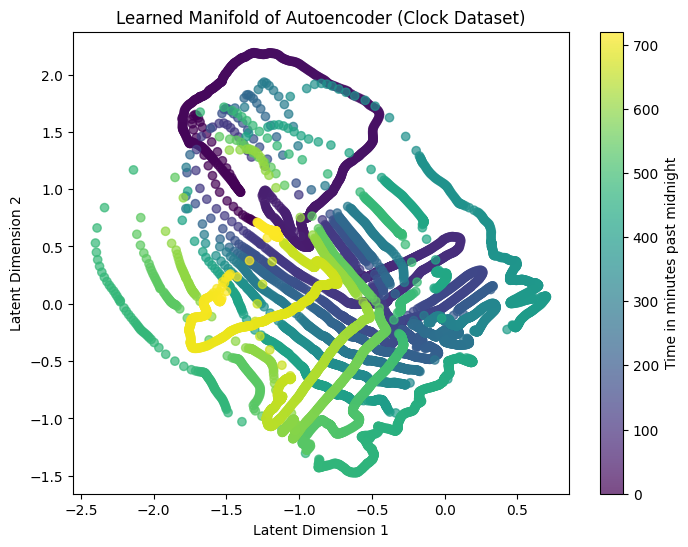

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA


# Extract latent representations
latents = []
labels = []

with torch.no_grad():
    for images, label_2d, label_1d in dataloader:
        images = images.to(device)
        _, out = model(images)
        latents.append(out.cpu().numpy())
        labels.append(label_1d.numpy())

latents = np.concatenate(latents, axis=0)
labels = np.concatenate(labels, axis=0) * (12 * 60)  # Denormalize to minutes past midnight


if (OUT_DIM <= 2):
  # Plot latent space
  plt.figure(figsize=(8, 6))
  scatter = plt.scatter(latents[:, 0], labels if OUT_DIM==1 else latents[:,1], c=labels, cmap="viridis", alpha=0.7)
  plt.colorbar(scatter, label="Time in minutes past midnight")
  plt.xlabel("Latent Dimension 1")
  plt.ylabel("Time in minutes past midnight" if OUT_DIM==1 else "Latent Dimension 2")
  plt.title("Learned Manifold of Autoencoder (Clock Dataset)")
  plt.show()
else:
  # PCA for dimensionality reduction
  pca = PCA(n_components=2)
  latents_2d = pca.fit_transform(latents)

  # Plot PCA-reduced latent space
  plt.figure(figsize=(8, 6))
  scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap="viridis", alpha=0.7)
  plt.colorbar(scatter, label="Time in minutes past midnight")
  plt.xlabel("PCA Component 1")
  plt.ylabel("PCA Component 2")
  plt.title("Learned Manifold of Autoencoder (Clock Dataset)")
  plt.show()



## Visualize reconstruction

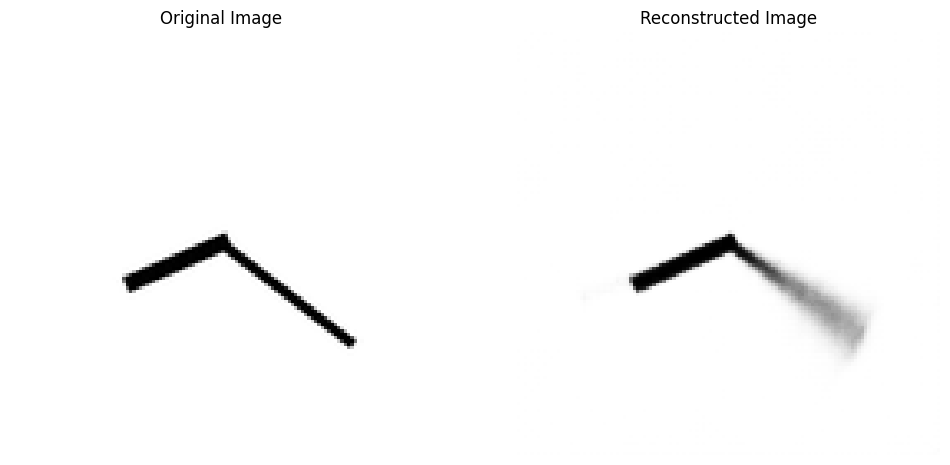

In [55]:
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(dataset))
img = dataset[idx][0]

img = img.unsqueeze(0).to(device)
out, latent = model(img)
img = img.squeeze(0).detach().cpu().numpy()
out = out.squeeze(0).detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img[0], cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(out[0], cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()



# Visualize Regressor latents

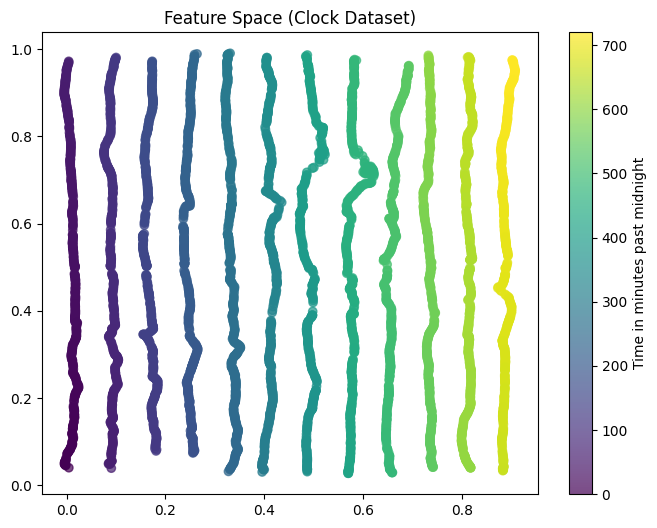

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from clock_dataset import IMG_DIR, IMG_SIZE, ClockDataset
from models import ClockRegressor, ClockRegressorAE
import os

# Load trained model
OUT_DIM = 2
MODELS_DIR = "models"
model_file = f"regressor-{OUT_DIM}-e100-p7.pth"
probe_model_file = f"ae_{model_file}"

model_path = os.path.join(MODELS_DIR, model_file)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ClockRegressor(out_dim=OUT_DIM, input_dim=IMG_SIZE).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

probe = ClockRegressorAE(hidden_units=OUT_DIM).to(device)
probe.load_state_dict(torch.load(os.path.join(MODELS_DIR, probe_model_file), map_location=device))
probe.eval()

# Load dataset
subset_size = 5000
subset_indices = np.random.choice(len(dataset), size=subset_size, replace=False)
subset_sampler = torch.utils.data.Subset(dataset, subset_indices)
subset_dataloader = DataLoader(subset_sampler, batch_size=subset_size, shuffle=False)

# Extract latent representations
feats = []
labels = []

with torch.no_grad():
  for images, label_2d, label_1d in subset_dataloader:
    images = images.to(device)
    out = model.forward(images)
    # _, latent = probe(out)
    feats.append(out.cpu().numpy())
    labels.append(label_1d.numpy())


feats = np.concatenate(feats, axis=0)
labels = np.concatenate(labels, axis=0) * (12 * 60)  # Denormalize to minutes past midnight

# Plot latent space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(feats[:, 0], feats[:, 1], c=labels, cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="Time in minutes past midnight")
plt.title("Feature Space (Clock Dataset)")
plt.show()


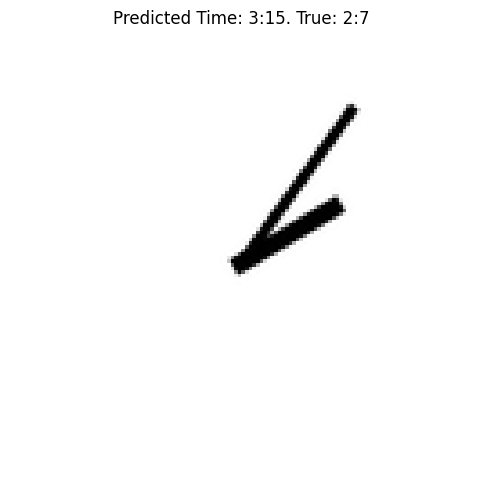

In [16]:
import matplotlib.pyplot as plt

# Get random image from dataset
idx = np.random.randint(0, len(dataset))
img, true_time, _ = dataset[idx]

out = model(img.unsqueeze(0).to(device))
img = img.numpy()
out = out.cpu().detach().numpy()

true_time_hour = int(true_time[0] * 12)
true_time_minute = int(true_time[1] * 60)

plt.figure(figsize=(12, 6))
plt.imshow(img[0], cmap='gray')

plt.title(f"Predicted Time: {int(out[0][0]*12)}:{int(out[0][1]*60)}. True: {true_time_hour}:{true_time_minute}")
plt.axis('off')
plt.show()



